**Nithun Selva and Saad Khan**

Spring 2025

CS 444: Deep Learning

Project 2: Branch Neural Networks

#### Week 2: Residual networks

The focus this week is on the ResNet architecture. You will build several neural networks in the ResNet family and and train them on CIFAR-10 and CIFAR-100.

In [1]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=7)

# Automatically reload your external source code
%load_ext autoreload
%autoreload 2

## Task 6: The Residual Block

This task focuses on implementing and testing the **Residual Block** in preparation of creating the first ResNet (**ResNet-8**). 

Much like how Inception Blocks represent the building blocks of Inception Net, stacks of Residual Blocks represent the basis of ResNet. Residual Blocks possess a simpler structure than Inception Blocks — they only contain two parallel branches with fewer layers. Here is a refresher on the structure of the branches:

**Main branch:** sequence of two 2D convolutional layers.

**Residual branch:** the input signal to the Residual Block passes through "as-is", without modification (usually).

Like Inception Block, the output of both branches comes together at the end of the block. However, the branch outputs are SUMMED together rather than being concatenated.


This is the story for most Residual Blocks, however, like most CNNs:
1. the spatial resolution of the activations occasionally decreases
2. the number of conv filters/neurons increases

as we go deeper in a ResNet. Both of these factors tend to change *at the same time* in a small number of Residual Blocks located at various depths of the ResNet. Put another way, the spatial resolution and number of filters tends to remain constant across most successive Residual Blocks and they only changes in a few blocks throughout the net.
1. The decrease in spatial resolution is implemented in these small number of Residual Blocks with a convolutional stride > 1.
2. A 1x1 convolutional layer is needed as the "special sauce" along the residual branch to make the shapes of signals in both branches match (*otherwise they could not be summed!*).

### 6a. Implement and test the Residual Block

The class is in `residual_block.py`.

In [11]:
from residual_block import ResidualBlock

#### Test: `ResidualBlock` Stride 1 (1/2)

In [12]:
# Testing architecture and shapes
# Stride 1
tf.random.set_seed(0)
res1 = ResidualBlock('TestResidualBlock_S1', 7, prev_layer_or_block=None, strides=1)
res1(tf.ones([1, 4, 4, 7]))
print(res1)

TestResidualBlock_S1:
	Conv2D layer output(TestResidualBlock_S1/main_3x3conv_2) shape: [1, 4, 4, 7]
	Conv2D layer output(TestResidualBlock_S1/main_3x3conv_1) shape: [1, 4, 4, 7]


The above cell should print:

```
TestResidualBlock_S1:
	Conv2D layer output(TestResidualBlock_S1/main_3x3conv_2) shape: [1, 4, 4, 7]
	Conv2D layer output(TestResidualBlock_S1/main_3x3conv_1) shape: [1, 4, 4, 7]
```

In [13]:
# Test activations
tf.random.set_seed(0)
net_acts1 = res1(tf.random.uniform([2, 4, 4, 7]))
print(f'The shape of the netAct output from the block is {net_acts1.shape} and should be (2, 4, 4, 7)')
print(f'The first few activations are:\n{net_acts1[0,:,:, 0]}')
print('and should be:')
print('''[[0.        0.520823  0.1888617 0.       ]
 [0.        0.7621396 0.1734907 0.8486798]
 [0.        0.6156113 0.4272216 0.       ]
 [0.5561852 0.4888234 1.0138503 0.5533389]]''')

The shape of the netAct output from the block is (2, 4, 4, 7) and should be (2, 4, 4, 7)
The first few activations are:
[[0.        0.5217761 0.1893243 0.       ]
 [0.        0.7621545 0.1734996 0.8485928]
 [0.        0.6153203 0.4271709 0.       ]
 [0.5565346 0.4890186 1.0133624 0.5532338]]
and should be:
[[0.        0.520823  0.1888617 0.       ]
 [0.        0.7621396 0.1734907 0.8486798]
 [0.        0.6156113 0.4272216 0.       ]
 [0.5561852 0.4888234 1.0138503 0.5533389]]


#### Test: `ResidualBlock` Stride 2 (2/2)

In [6]:
# Testing architecture and shapes
# Stride 2
tf.random.set_seed(0)
res2 = ResidualBlock('TestResidualBlock_S2', 5, prev_layer_or_block=None, strides=2)
res2(tf.ones([1, 6, 6, 5]))
print(res2)

TestResidualBlock_S2:
	Conv2D layer output(TestResidualBlock_S2/main_3x3conv_2) shape: [1, 3, 3, 5]
	Conv2D layer output(TestResidualBlock_S2/main_3x3conv_1) shape: [1, 3, 3, 5]
	-->Conv2D1x1 layer output(TestResidualBlock_S2/skip_conv1x1) shape: [1, 3, 3, 5]-->


The above cell should print:

```
TestResidualBlock_S2:
	Conv2D layer output(TestResidualBlock_S2/main_3x3conv_2) shape: [1, 3, 3, 5]
	Conv2D layer output(TestResidualBlock_S2/main_3x3conv_1) shape: [1, 3, 3, 5]
	-->Conv2D1x1 layer output(TestResidualBlock_S2/skip_conv1x1) shape: [1, 3, 3, 5]-->
```

*The layer with the --> is the residual branch.*

In [8]:
# Test activations
tf.random.set_seed(0)
net_acts2 = res2(tf.random.uniform([3, 6, 6, 5]))
print(f'The shape of the netAct output from the block is {net_acts2.shape} and should be (3, 3, 3, 5)')
print(f'The first few activations are:\n{net_acts2[0,:,:, :]}')
print('and should be:')
print('''[[[0.2404823 0.        0.        0.2851936 0.       ]
  [0.        0.        0.        0.1339086 0.6898913]
  [0.        0.        0.        0.4596353 0.2781557]]

 [[0.        0.        0.        0.6591434 1.3703969]
  [0.2665227 0.        0.        0.9614864 0.       ]
  [0.        0.        0.        0.3844326 0.7111533]]

 [[0.0933782 0.        0.        0.1378801 0.3006183]
  [0.1873689 0.        0.        0.4464224 1.1067129]
  [0.        0.        0.        0.7910071 0.345379 ]]]''')

The shape of the netAct output from the block is (3, 3, 3, 5) and should be (3, 3, 3, 5)
The first few activations are:
[[[0.2394033 0.        0.        0.2849714 0.       ]
  [0.        0.        0.        0.1339354 0.6888489]
  [0.        0.        0.        0.459016  0.2780276]]

 [[0.        0.        0.        0.6580622 1.3681687]
  [0.2652387 0.        0.        0.9599936 0.       ]
  [0.        0.        0.        0.3840208 0.7103187]]

 [[0.092894  0.        0.        0.1376765 0.3002029]
  [0.186844  0.        0.        0.4456812 1.1048379]
  [0.        0.        0.        0.7899526 0.3448124]]]
and should be:
[[[0.2404823 0.        0.        0.2851936 0.       ]
  [0.        0.        0.        0.1339086 0.6898913]
  [0.        0.        0.        0.4596353 0.2781557]]

 [[0.        0.        0.        0.6591434 1.3703969]
  [0.2665227 0.        0.        0.9614864 0.       ]
  [0.        0.        0.        0.3844326 0.7111533]]

 [[0.0933782 0.        0.        0.1378801 0.

## Task 7: ResNet-8

Assemble the Residual Blocks and several other layers to build ResNet-8:

Conv2D → ResidualBlock → ResidualBlock → ResidualBlock → GlobalAveragePooling2D → Dense

After an overfit test to help check whether the network is working, you will train the network on both CIFAR-10 and CIFAR-100.

In [6]:
from resnets import ResNet8

### 7a. Build ResNet-8

Implement the following classes in `resnets.py`:
1. `ResNet`: Parent class of all specific ResNets (e.g. ResNet-8, ResNet-18, etc.). Having this class helps reduce code size/duplication because the forward pass thru all ResNets is exactly the same!
2. `ResNet8`: Assemble the first (*and smallest*) net in the family!

#### Test: `ResNet8` architecture and shapes

In [17]:
res8 = ResNet8(C=3, input_feats_shape=(32, 32, 3))
res8.compile()

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 3]
Global Avg Pooling 2D layer output(GlobalAvgPool2D) shape: [1, 128]
ResidualBlock3:
	Conv2D layer output(ResidualBlock3/main_3x3conv_2) shape: [1, 8, 8, 128]
	Conv2D layer output(ResidualBlock3/main_3x3conv_1) shape: [1, 8, 8, 128]
	-->Conv2D1x1 layer output(ResidualBlock3/skip_conv1x1) shape: [1, 8, 8, 128]-->
ResidualBlock2:
	Conv2D layer output(ResidualBlock2/main_3x3conv_2) shape: [1, 16, 16, 64]
	Conv2D layer output(ResidualBlock2/main_3x3conv_1) shape: [1, 16, 16, 64]
	-->Conv2D1x1 layer output(ResidualBlock2/skip_conv1x1) shape: [1, 16, 16, 64]-->
ResidualBlock1:
	Conv2D layer output(ResidualBlock1/main_3x3conv_2) shape: [1, 32, 32, 32]
	Conv2D layer output(ResidualBlock1/main_3x3conv_1) shape: [1, 32, 32, 32]
Conv2D layer output(Conv2D_1) shape: [1, 32, 32, 32]


The above cell should print:

```
---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 3]
Global Avg Pooling 2D layer output(GlobalAvgPool2D) shape: [1, 128]
ResidualBlock_3:
	Conv2D layer output(ResidualBlock_3/main_3x3conv_2) shape: [1, 8, 8, 128]
	Conv2D layer output(ResidualBlock_3/main_3x3conv_1) shape: [1, 8, 8, 128]
	-->Conv2D1x1 layer output(ResidualBlock_3/skip_conv1x1) shape: [1, 8, 8, 128]-->
ResidualBlock_2:
	Conv2D layer output(ResidualBlock_2/main_3x3conv_2) shape: [1, 16, 16, 64]
	Conv2D layer output(ResidualBlock_2/main_3x3conv_1) shape: [1, 16, 16, 64]
	-->Conv2D1x1 layer output(ResidualBlock_2/skip_conv1x1) shape: [1, 16, 16, 64]-->
ResidualBlock_1:
	Conv2D layer output(ResidualBlock_1/main_3x3conv_2) shape: [1, 32, 32, 32]
	Conv2D layer output(ResidualBlock_1/main_3x3conv_1) shape: [1, 32, 32, 32]
Conv2D layer output(Conv2D_1) shape: [1, 32, 32, 32]
```

### 7b. CIFAR-10 overfit test

In the cell below, import CIFAR-10 and reproduce our usual overfit protocol:
1. Create a dev set from the 1st 500 training CIFAR-10 samples.
2. Train your net on the dev set for `80` epochs (turn off early stopping for this test). *Do not use any regularization.* 

Your training loss should start out at ~2.3 after the first epoch and rapidly plummet to 0.01 or less by about 70 epochs.

**Note:** If you coded `fit` to assume there will always be a validation set present, no problem, just plug in the dev set for both the train and val sets.

In [1]:
from datasets import get_dataset

2025-04-13 19:59:34.578119: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-13 19:59:34.792282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744588774.874525    7424 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744588774.897594    7424 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-13 19:59:35.097422: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
x_train, y_train, x_val, y_val, x_test, y_test, classnames = get_dataset('cifar10')
x_dev = x_train[:500]
y_dev = y_train[:500]

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

# YOUR CODE HERE
res8 = ResNet8(C=10, input_feats_shape=(32, 32, 3))
res8.compile()
#train model on dev set for 80 epochs
train_loss_hist, val_loss_hist, val_acc_hist, e = res8.fit(x_dev, y_dev, x_dev, y_dev, max_epochs=80)




---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 10]
Global Avg Pooling 2D layer output(GlobalAvgPool2D) shape: [1, 128]
ResidualBlock3:
	Conv2D layer output(ResidualBlock3/main_3x3conv_2) shape: [1, 8, 8, 128]
	Conv2D layer output(ResidualBlock3/main_3x3conv_1) shape: [1, 8, 8, 128]
	-->Conv2D1x1 layer output(ResidualBlock3/skip_conv1x1) shape: [1, 8, 8, 128]-->
ResidualBlock2:
	Conv2D layer output(ResidualBlock2/main_3x3conv_2) shape: [1, 16, 16, 64]
	Conv2D layer output(ResidualBlock2/main_3x3conv_1) shape: [1, 16, 16, 64]
	-->Conv2D1x1 layer output(ResidualBlock2/skip_conv1x1) shape: [1, 16, 16, 64]-->
ResidualBlock1:
	Conv2D layer output(ResidualBlock1/main_3x3conv_2) shape: [1, 32, 32, 32]
	Conv2D layer output(ResidualBlock1/main_3x3conv_1) shape: [1, 32, 32, 32]
Conv2D layer output(Conv2D_1) shape: [1, 32, 32, 32]


2025-04-13 20:06:20.392448: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1127', 4 bytes spill stores, 4 bytes spill loads

2025-04-13 20:06:20.564433: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1127', 32 bytes spill stores, 32 bytes spill loads

2025-04-13 20:06:20.712948: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1127', 248 bytes spill stores, 248 bytes spill loads

2025-04-13 20:06:20.757202: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1127', 240 bytes spill stores, 240 bytes spill loads



Epoch 1/80 - Train Loss: 2.2900, Val Loss: 3.5725, Val Acc: 0.1295
Epoch 1 completed in 14.65 seconds.
Epoch 2/80 - Train Loss: 1.9012, Val Loss: 3.7320, Val Acc: 0.1295
Epoch 2 completed in 0.05 seconds.
Epoch 3/80 - Train Loss: 1.6733, Val Loss: 3.5871, Val Acc: 0.1295
Epoch 3 completed in 0.05 seconds.
Epoch 4/80 - Train Loss: 1.5556, Val Loss: 3.6811, Val Acc: 0.1295
Epoch 4 completed in 0.05 seconds.
Epoch 5/80 - Train Loss: 1.4391, Val Loss: 3.5644, Val Acc: 0.1406
Epoch 5 completed in 0.05 seconds.
Epoch 6/80 - Train Loss: 1.3279, Val Loss: 3.6717, Val Acc: 0.1496
Epoch 6 completed in 0.05 seconds.
Epoch 7/80 - Train Loss: 1.2256, Val Loss: 3.5390, Val Acc: 0.1741
Epoch 7 completed in 0.05 seconds.
Epoch 8/80 - Train Loss: 1.1527, Val Loss: 3.0325, Val Acc: 0.1853
Epoch 8 completed in 0.05 seconds.
Epoch 9/80 - Train Loss: 1.0517, Val Loss: 3.1294, Val Acc: 0.1920
Epoch 9 completed in 0.05 seconds.
Epoch 10/80 - Train Loss: 0.9612, Val Loss: 2.3911, Val Acc: 0.2433
Epoch 10 comp

### 7c. Train ResNet-8 on CIFAR-10

Repeat our usual training and evaluation protocol:
1. Train ResNet-8 on CIFAR-10. Use regularization strength of `1.5`, a patience of `15`, learning rate patience of `4`, and keep the rest of the hyperparameters to their defaults.
2. Print the test accuracy.

If everything is working as expected, you should get a test accuracy in the 80s.

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

res8 = ResNet8(C=10, input_feats_shape=(32, 32, 3), reg=1.5)
res8.compile(optimizer='adamw')
train_loss_hist, val_loss_hist, val_acc_hist, e = res8.fit(x_train, y_train, x_val, y_val, patience=15, lr_patience=4 )
acc, loss = res8.evaluate(x_test, y_test)
print(f'Test accuracy is {acc} and test loss is {loss}')


---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 10]
Global Avg Pooling 2D layer output(GlobalAvgPool2D) shape: [1, 128]
ResidualBlock3:
	Conv2D layer output(ResidualBlock3/main_3x3conv_2) shape: [1, 8, 8, 128]
	Conv2D layer output(ResidualBlock3/main_3x3conv_1) shape: [1, 8, 8, 128]
	-->Conv2D1x1 layer output(ResidualBlock3/skip_conv1x1) shape: [1, 8, 8, 128]-->
ResidualBlock2:
	Conv2D layer output(ResidualBlock2/main_3x3conv_2) shape: [1, 16, 16, 64]
	Conv2D layer output(ResidualBlock2/main_3x3conv_1) shape: [1, 16, 16, 64]
	-->Conv2D1x1 layer output(ResidualBlock2/skip_conv1x1) shape: [1, 16, 16, 64]-->
ResidualBlock1:
	Conv2D layer output(ResidualBlock1/main_3x3conv_2) shape: [1, 32, 32, 32]
	Conv2D layer output(ResidualBlock1/main_3x3conv_1) shape: [1, 32, 32, 32]
Conv2D layer output(Conv2D_1) shape: [1, 32, 32, 32]


2025-04-13 20:10:32.548444: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2014', 240 bytes spill stores, 240 bytes spill loads

2025-04-13 20:10:32.589271: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2014', 32 bytes spill stores, 32 bytes spill loads

2025-04-13 20:10:32.712951: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2014', 4 bytes spill stores, 4 bytes spill loads

2025-04-13 20:10:33.359631: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2014', 248 bytes spill stores, 248 bytes spill loads



Epoch 1/10000 - Train Loss: 1.4001, Val Loss: 2.5339, Val Acc: 0.1504
Epoch 1 completed in 20.21 seconds.
Epoch 2/10000 - Train Loss: 1.0800, Val Loss: 2.5264, Val Acc: 0.1895
Epoch 2 completed in 4.29 seconds.
Epoch 3/10000 - Train Loss: 0.9639, Val Loss: 2.3663, Val Acc: 0.2125
Epoch 3 completed in 4.41 seconds.
Epoch 4/10000 - Train Loss: 0.8976, Val Loss: 1.7514, Val Acc: 0.4073
Epoch 4 completed in 4.13 seconds.
Epoch 5/10000 - Train Loss: 0.8500, Val Loss: 1.7636, Val Acc: 0.4215
Epoch 5 completed in 3.99 seconds.
Epoch 6/10000 - Train Loss: 0.7990, Val Loss: 1.1377, Val Acc: 0.6158
Epoch 6 completed in 3.98 seconds.
Epoch 7/10000 - Train Loss: 0.7642, Val Loss: 1.7044, Val Acc: 0.4058
Epoch 7 completed in 3.97 seconds.
Epoch 8/10000 - Train Loss: 0.7444, Val Loss: 1.1399, Val Acc: 0.6226
Epoch 8 completed in 4.00 seconds.
Epoch 9/10000 - Train Loss: 0.7268, Val Loss: 0.9521, Val Acc: 0.6703
Epoch 9 completed in 3.98 seconds.
Epoch 10/10000 - Train Loss: 0.7081, Val Loss: 1.3276,

### 7d. Train ResNet-8 on CIFAR-100

Repeat what you did with CIFAR-10, but this time with CIFAR-100.

The test accuracy that you achieve should be better than chance, but should NOT be satisfying.

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

x_train, y_train, x_val, y_val, x_test, y_test, classnames = get_dataset('cifar100')


res8 = ResNet8(C=100, input_feats_shape=(32, 32, 3), reg=1.5)
res8.compile(optimizer='adamw')
train_loss_hist, val_loss_hist, val_acc_hist, e = res8.fit(x_train, y_train, x_val, y_val, patience=15, lr_patience=4 )
acc, loss = res8.evaluate(x_test, y_test)
print(f'Test accuracy is {acc} and test loss is {loss}')



---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 100]
Global Avg Pooling 2D layer output(GlobalAvgPool2D) shape: [1, 128]
ResidualBlock3:
	Conv2D layer output(ResidualBlock3/main_3x3conv_2) shape: [1, 8, 8, 128]
	Conv2D layer output(ResidualBlock3/main_3x3conv_1) shape: [1, 8, 8, 128]
	-->Conv2D1x1 layer output(ResidualBlock3/skip_conv1x1) shape: [1, 8, 8, 128]-->
ResidualBlock2:
	Conv2D layer output(ResidualBlock2/main_3x3conv_2) shape: [1, 16, 16, 64]
	Conv2D layer output(ResidualBlock2/main_3x3conv_1) shape: [1, 16, 16, 64]
	-->Conv2D1x1 layer output(ResidualBlock2/skip_conv1x1) shape: [1, 16, 16, 64]-->
ResidualBlock1:
	Conv2D layer output(ResidualBlock1/main_3x3conv_2) shape: [1, 32, 32, 32]
	Conv2D layer output(ResidualBlock1/main_3x3conv_1) shape: [1, 32, 32, 32]
Conv2D layer output(Conv2D_1) shape: [1, 32, 32, 32]


2025-04-13 20:17:04.753539: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2303', 16 bytes spill stores, 16 bytes spill loads

2025-04-13 20:17:05.645556: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4255', 20 bytes spill stores, 24 bytes spill loads



Epoch 1/10000 - Train Loss: 3.8402, Val Loss: 4.3323, Val Acc: 0.0553
Epoch 1 completed in 20.89 seconds.
Epoch 2/10000 - Train Loss: 3.3537, Val Loss: 4.2215, Val Acc: 0.0621
Epoch 2 completed in 4.51 seconds.
Epoch 3/10000 - Train Loss: 3.1220, Val Loss: 4.3023, Val Acc: 0.0531
Epoch 3 completed in 4.28 seconds.
Epoch 4/10000 - Train Loss: 2.9678, Val Loss: 3.9991, Val Acc: 0.0879
Epoch 4 completed in 4.23 seconds.
Epoch 5/10000 - Train Loss: 2.8543, Val Loss: 3.3069, Val Acc: 0.2037
Epoch 5 completed in 5.01 seconds.
Epoch 6/10000 - Train Loss: 2.7696, Val Loss: 3.5804, Val Acc: 0.1524
Epoch 6 completed in 4.11 seconds.
Epoch 7/10000 - Train Loss: 2.7123, Val Loss: 3.8018, Val Acc: 0.1244
Epoch 7 completed in 3.59 seconds.
Epoch 8/10000 - Train Loss: 2.6776, Val Loss: 3.2709, Val Acc: 0.2029
Epoch 8 completed in 3.71 seconds.
Epoch 9/10000 - Train Loss: 2.6396, Val Loss: 3.3222, Val Acc: 0.2031
Epoch 9 completed in 3.96 seconds.
Epoch 10/10000 - Train Loss: 2.6164, Val Loss: 3.4093,

### 7e. Questions

**Question 3:** Compare your ResNet-8 with Inception Net with respect to CIFAR-10 test accuracy, runtime (per epoch), and the train/val loss progression throughout training. 

**Question 4:** How did ResNet-8 do on at CIFAR-100 test set classification compared to Inception Net?

**Answer 3:** ResNet-8 took less than half the time Inception Net took per epoch, at around ~4 seconds vs ~9.5 seconds. ResNet-8 had slightly lower test accuracy at ~0.84 vs ~0.89 in Inception Net. Inception Net makes bigger jumps down the loss curve, showing rapid decreases in both val/train loss between epochs, while ResNet takes more gradual steps. ResNet-8 also had slightly higher final loss values. ResNet took 65 epochs to converge, with a final train Loss of 0.0463 and val Loss of 0.4450, while Inception Net took 43 epochs and stopped at a train loss of 0.0025 and val Loss of 0.3860.

**Answer 4:** A decent bit worse, with ResNet-8 scoring a test accuracy of ~0.50 and test loss of ~2.01, while Inception Net scored a test accuracy of ~0.62, and a test loss of ~1.52.

## Task 8: ResNet-18

ResNet is an incredibly flexible/extensible neural network architecture. To get a better sense of this, let's build a deeper ResNet then train it on CIFAR-100.

### 8a. Stacking multiple Residual Blocks together in sequence

In ResNet-8, the spatial resolution/number of filters changed in every residual block. In deeper ResNets, this is not usually the case — there is a "string"/sequence of Residual Blocks with the SAME resolution and filter count stacked together after the change occurs.

To streamline the process of stacking multiple Residual Blocks with the same hyperparameters together, write the `stack_residualblocks` function in `resnets.py`. This should save you lots of copy-pasting and/or typing!

In [12]:
from resnets import stack_residualblocks

#### Test: `stack_residualblocks`

In [13]:
for i in range(4):
    test_stack = stack_residualblocks('TestStack', 4, i+1, prev_layer_or_block=None, first_block_stride=1)
    print(f'There are {len(test_stack)} blocks in the residual stack. There should be {i+1}.')

strides_in_stack = [block.strides for block in test_stack]
print(f'The strides in each block are: {strides_in_stack}. They should be [1, 1, 1, 1]')

test_stack = stack_residualblocks('TestStack', 4, 3, prev_layer_or_block=None, first_block_stride=2)
strides_in_stack = [block.strides for block in test_stack]
print(f'The strides in each block are: {strides_in_stack}. They should be [2, 1, 1]')


There are 1 blocks in the residual stack. There should be 1.
There are 2 blocks in the residual stack. There should be 2.
There are 3 blocks in the residual stack. There should be 3.
There are 4 blocks in the residual stack. There should be 4.
The strides in each block are: [1, 1, 1, 1]. They should be [1, 1, 1, 1]
The strides in each block are: [2, 1, 1]. They should be [2, 1, 1]


In [14]:
print('The blocks are:')
for block in test_stack:
    print(block)

The blocks are:
TestStack/block_1:
	Conv2D layer output(TestStack/block_1/main_3x3conv_2) shape: None
	Conv2D layer output(TestStack/block_1/main_3x3conv_1) shape: None
	-->Conv2D1x1 layer output(TestStack/block_1/skip_conv1x1) shape: None-->
TestStack/block_2:
	Conv2D layer output(TestStack/block_2/main_3x3conv_2) shape: None
	Conv2D layer output(TestStack/block_2/main_3x3conv_1) shape: None
TestStack/block_3:
	Conv2D layer output(TestStack/block_3/main_3x3conv_2) shape: None
	Conv2D layer output(TestStack/block_3/main_3x3conv_1) shape: None


The above should print:

```
The blocks are:
TestStack/block_1:
	Conv2D layer output(TestStack/block_1/main_3x3conv_2) shape: None
	Conv2D layer output(TestStack/block_1/main_3x3conv_1) shape: None
	-->Conv2D1x1 layer output(TestStack/block_1/skip_conv1x1) shape: None-->
TestStack/block_2:
	Conv2D layer output(TestStack/block_2/main_3x3conv_2) shape: None
	Conv2D layer output(TestStack/block_2/main_3x3conv_1) shape: None
TestStack/block_3:
	Conv2D layer output(TestStack/block_3/main_3x3conv_2) shape: None
	Conv2D layer output(TestStack/block_3/main_3x3conv_1) shape: None
```

### 8b. Build ResNet-18

Implement the `ResNet18` class in `resnets.py`.

In [15]:
from resnets import ResNet18

#### Test: `ResNet18`

In [16]:
res18 = ResNet18(C=4, input_feats_shape=(32, 32, 3))
res18.compile()

---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 4]
Global Avg Pooling 2D layer output(global_avg_pool) shape: [1, 512]
stack_4/block_2:
	Conv2D layer output(stack_4/block_2/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack_4/block_2/main_3x3conv_1) shape: [1, 4, 4, 512]
stack_4/block_1:
	Conv2D layer output(stack_4/block_1/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack_4/block_1/main_3x3conv_1) shape: [1, 4, 4, 512]
	-->Conv2D1x1 layer output(stack_4/block_1/skip_conv1x1) shape: [1, 4, 4, 512]-->
stack_3/block_2:
	Conv2D layer output(stack_3/block_2/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack_3/block_2/main_3x3conv_1) shape: [1, 8, 8, 256]
stack_3/block_1:
	Conv2D layer output(stack_3/block_1/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack_3/block_1/main_3x3conv_1) shape: [1, 8, 8, 256]
	-->Conv2D1x1 layer output(stack_3/block_1/skip_conv1x1) shape: [

The above cell should print:

```
---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 4]
Global Avg Pooling 2D layer output(GlobalAvgPool2D) shape: [1, 512]
stack4/block_2:
	Conv2D layer output(stack4/block_2/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack4/block_2/main_3x3conv_1) shape: [1, 4, 4, 512]
stack4/block_1:
	Conv2D layer output(stack4/block_1/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack4/block_1/main_3x3conv_1) shape: [1, 4, 4, 512]
	-->Conv2D1x1 layer output(stack4/block_1/skip_conv1x1) shape: [1, 4, 4, 512]-->
stack3/block_2:
	Conv2D layer output(stack3/block_2/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack3/block_2/main_3x3conv_1) shape: [1, 8, 8, 256]
stack3/block_1:
	Conv2D layer output(stack3/block_1/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack3/block_1/main_3x3conv_1) shape: [1, 8, 8, 256]
	-->Conv2D1x1 layer output(stack3/block_1/skip_conv1x1) shape: [1, 8, 8, 256]-->
stack2/block_2:
	Conv2D layer output(stack2/block_2/main_3x3conv_2) shape: [1, 16, 16, 128]
	Conv2D layer output(stack2/block_2/main_3x3conv_1) shape: [1, 16, 16, 128]
stack2/block_1:
	Conv2D layer output(stack2/block_1/main_3x3conv_2) shape: [1, 16, 16, 128]
	Conv2D layer output(stack2/block_1/main_3x3conv_1) shape: [1, 16, 16, 128]
	-->Conv2D1x1 layer output(stack2/block_1/skip_conv1x1) shape: [1, 16, 16, 128]-->
stack1/block_2:
	Conv2D layer output(stack1/block_2/main_3x3conv_2) shape: [1, 32, 32, 64]
	Conv2D layer output(stack1/block_2/main_3x3conv_1) shape: [1, 32, 32, 64]
stack1/block_1:
	Conv2D layer output(stack1/block_1/main_3x3conv_2) shape: [1, 32, 32, 64]
	Conv2D layer output(stack1/block_1/main_3x3conv_1) shape: [1, 32, 32, 64]
Conv2D layer output(Conv2D_1) shape: [1, 32, 32, 64]
```

### 8c. Overfit ResNet-18 on CIFAR-100 dev set

Perform the usual overfitting protocol to test out your ResNet-18. However, this time use the 1st 500 samples of CIFAR-100 rather than CIFAR-10 to conduct the test.

In the cell below, import CIFAR-100 and reproduce our usual overfit protocol:
1. Create a dev set from the 1st 500 training CIFAR-100 samples.
2. Train your net on the dev set for `80` epochs (turn off early stopping for this test). *Do not use any regularization.* 

Your training loss should start out at ~4.7 after the first epoch and rapidly plummet to 0.01 or less after about 30 epochs.

In [19]:
from datasets import get_dataset
x_train, y_train, x_val, y_val, x_test, y_test, classnames = get_dataset('cifar100')
x_dev = x_train[:500]
y_dev = y_train[:500]

In [22]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

# YOUR CODE HERE
res18 = ResNet18(C=100, input_feats_shape=(32, 32, 3))
res18.compile()
train_loss_hist, val_loss_hist, val_acc_hist, e = res18.fit(x_dev, y_dev, x_dev, y_dev, max_epochs=80)

---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 100]
Global Avg Pooling 2D layer output(global_avg_pool) shape: [1, 512]
stack_4/block_2:
	Conv2D layer output(stack_4/block_2/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack_4/block_2/main_3x3conv_1) shape: [1, 4, 4, 512]
stack_4/block_1:
	Conv2D layer output(stack_4/block_1/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack_4/block_1/main_3x3conv_1) shape: [1, 4, 4, 512]
	-->Conv2D1x1 layer output(stack_4/block_1/skip_conv1x1) shape: [1, 4, 4, 512]-->
stack_3/block_2:
	Conv2D layer output(stack_3/block_2/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack_3/block_2/main_3x3conv_1) shape: [1, 8, 8, 256]
stack_3/block_1:
	Conv2D layer output(stack_3/block_1/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack_3/block_1/main_3x3conv_1) shape: [1, 8, 8, 256]
	-->Conv2D1x1 layer output(stack_3/block_1/skip_conv1x1) shape:

### 8d. Train ResNet-18 on CIFAR-100

In the cell below, train your ResNet-18 on CIFAR-100. Print out the test set after training concludes.

Use regularization strength of `1.5`, a patience of `15`, learning rate patience of `4`, and keep the rest of the hyperparameters to their defaults.

In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

res18 = ResNet18(C=100, input_feats_shape=(32, 32, 3), reg=1.5)
res18.compile(optimizer='adamw')
train_loss_hist, val_loss_hist, val_acc_hist, e = res18.fit(x_train, y_train, x_val, y_val, patience=15, lr_patience=4 )
acc, loss = res18.evaluate(x_test, y_test)
print(f'Test accuracy is {acc} and test loss is {loss}')



---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 100]
Global Avg Pooling 2D layer output(global_avg_pool) shape: [1, 512]
stack_4/block_2:
	Conv2D layer output(stack_4/block_2/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack_4/block_2/main_3x3conv_1) shape: [1, 4, 4, 512]
stack_4/block_1:
	Conv2D layer output(stack_4/block_1/main_3x3conv_2) shape: [1, 4, 4, 512]
	Conv2D layer output(stack_4/block_1/main_3x3conv_1) shape: [1, 4, 4, 512]
	-->Conv2D1x1 layer output(stack_4/block_1/skip_conv1x1) shape: [1, 4, 4, 512]-->
stack_3/block_2:
	Conv2D layer output(stack_3/block_2/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack_3/block_2/main_3x3conv_1) shape: [1, 8, 8, 256]
stack_3/block_1:
	Conv2D layer output(stack_3/block_1/main_3x3conv_2) shape: [1, 8, 8, 256]
	Conv2D layer output(stack_3/block_1/main_3x3conv_1) shape: [1, 8, 8, 256]
	-->Conv2D1x1 layer output(stack_3/block_1/skip_conv1x1) shape:

2025-04-13 20:53:39.461941: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2649', 112 bytes spill stores, 112 bytes spill loads

2025-04-13 20:53:39.661920: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2649', 24 bytes spill stores, 24 bytes spill loads

2025-04-13 20:53:39.928428: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4233_0', 248 bytes spill stores, 248 bytes spill loads

2025-04-13 20:53:40.061231: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4704', 8 bytes spill stores, 8 bytes spill loads

2025-04-13 20:53:40.076593: I external/local_xla/xla/str

Epoch 1/10000 - Train Loss: 3.6029, Val Loss: 5.1996, Val Acc: 0.0164
Epoch 1 completed in 55.85 seconds.
Epoch 2/10000 - Train Loss: 2.7730, Val Loss: 4.5846, Val Acc: 0.0631
Epoch 2 completed in 20.44 seconds.
Epoch 3/10000 - Train Loss: 2.3340, Val Loss: 4.6114, Val Acc: 0.0591
Epoch 3 completed in 19.68 seconds.
Epoch 4/10000 - Train Loss: 2.0814, Val Loss: 5.0700, Val Acc: 0.0485
Epoch 4 completed in 20.96 seconds.
Epoch 5/10000 - Train Loss: 1.8920, Val Loss: 4.0797, Val Acc: 0.1140
Epoch 5 completed in 21.32 seconds.
Epoch 6/10000 - Train Loss: 1.7658, Val Loss: 3.5030, Val Acc: 0.2073
Epoch 6 completed in 22.79 seconds.
Epoch 7/10000 - Train Loss: 1.6816, Val Loss: 3.2845, Val Acc: 0.2137
Epoch 7 completed in 21.86 seconds.
Epoch 8/10000 - Train Loss: 1.6284, Val Loss: 3.1630, Val Acc: 0.2580
Epoch 8 completed in 21.47 seconds.
Epoch 9/10000 - Train Loss: 1.5799, Val Loss: 2.9998, Val Acc: 0.2752
Epoch 9 completed in 21.16 seconds.
Epoch 10/10000 - Train Loss: 1.5516, Val Loss:

### 8e. Visualize the predictions made by ResNet-18 on the CIFAR-100 test set.

In the cell below, use your trained ResNet-18 to get the predicted classes of thr 1st 225 test set images.

In [26]:
y100_test = y_test
y_pred = res18.predict(x_test[:225])
y_pred = tf.cast(y_pred, tf.int32)

Run the code below to create a 15x15 grid of CIFAR-100 images with the true and predicted classes in the title. The predicted classes are color-coded  blue if they are correct, red if they are incorrect.

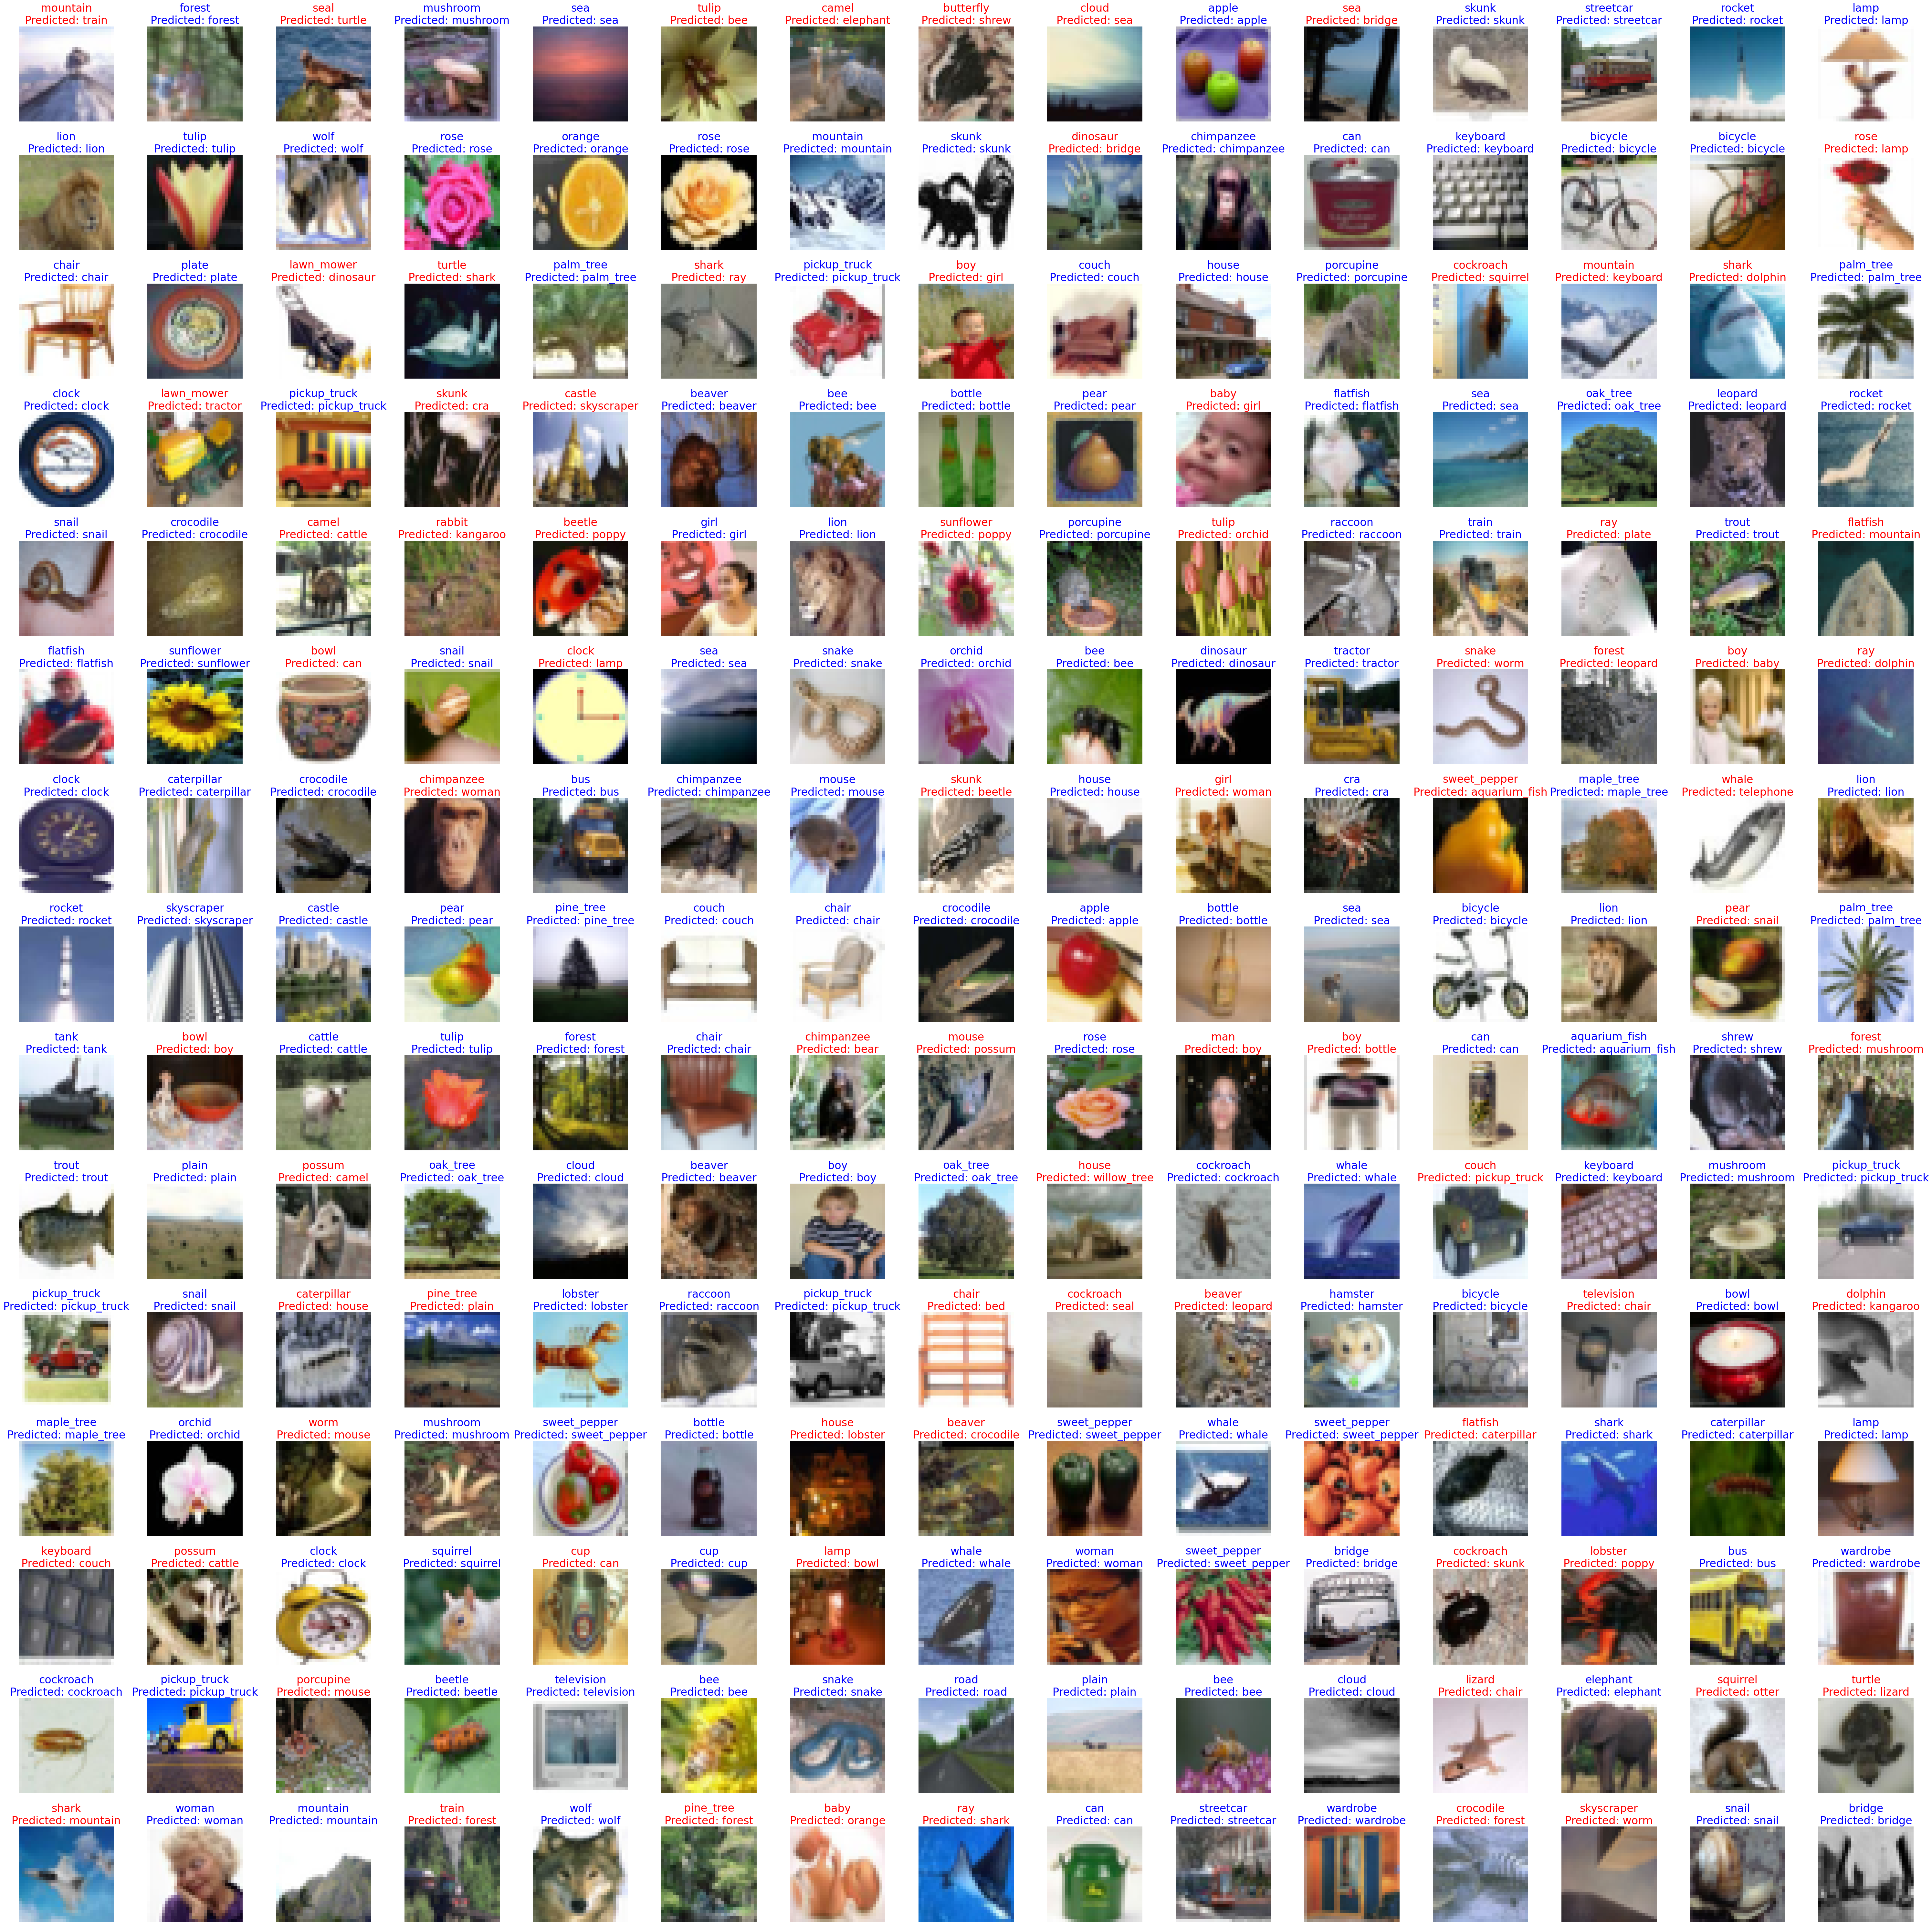

In [27]:
_,_,_,_, x100_test_vis, y100_test_vis, classnames = get_dataset('cifar100', standardize_ds=False)

panel_sz = 4
grid = 15
fig, axes, = plt.subplots(nrows=grid, ncols=grid, figsize=(grid*panel_sz, grid*panel_sz))

for r in range(grid):
    for c in range(grid):
        ind = grid*r + c
        axes[r,c].imshow(x100_test_vis[ind])
        axes[r,c].set_xticks([])
        axes[r,c].set_yticks([])
        title = f'{classnames[y100_test[ind]]}\nPredicted: '
        title += f'{classnames[y_pred[ind]]}'

        color = 'blue'
        if y100_test[ind] != y_pred[ind]:
            color = 'red'

        axes[r,c].set_title(title, color=color)
plt.tight_layout()
plt.show()


### 8f. Questions

**Question 5:** Take a look at the above montage. Does the mistakes made by ResNet-18 seem reasonable? Provide some specific examples to support your conclusion.

**Answer 5:** Yes, as often times it will classify an image based on other information that is also present in the image. For example, it predicted a bee as a tulip - but this is likely because of the flower the bee is sitting on. It predicted a cockroach as a skunk, but the cockroach also has a white line on its black body, much like the coloration of a skunk. In images with trees, such as a train against foliage or a pine tree, the network classifies the image as a forest, due to the presence of repeated, green, tree-like patterns. In other scenarios, it will correctly predict the superclass, i.e food containers, but mistake the individual classes due to small details between them, such as a cup for a can or a can instead of a bowl.

## Extensions

### General guidelines

1. Never integrate extensions into your base project so that they change the expected behavior of core functions. If your extension changes the core design/behavior, no problem, duplicate your working base project and add features from there.
2. Check the rubric to keep in mind how extensions on this project will be graded.
3. While I may consult your code and "written log" of what you did, **I am grading your extensions based on what you present in your 3-5 min video.**
3. I suggest documenting your explorations in a "log" or "lab notebook" style (i.e. documenting your thought/progression/discovery/learning process). I'm not grading your writing, so you can keep it succinct. **Whatever is most useful to you to remember what you did.** 
4. I suggest taking a hypothesis driven approach. For example "I was curious about X so I explored Y. I found Z, which was not what I expected because..., so then tried A..."
5. Make plots to help showcase your results.
6. **More is not necessarily better.** Generally, a small number of "in-depth" extensions count for more than many "shallow" extensions.

### AI guidelines

You may use AI in mostly any capacity for extensions. However, keep in mind:
1. There is no need to use AI at all!
2. You are welcome to use AI as a tool (e.g. automate something that is tedious, help you get unstuck, etc.). However, you should be coding, you should be thinking, you should be writing, you should be creating. If you are spending most (or even close to most) of your time typing into a chatbot and copy-pasting, you have probably gone too far with AI use.
3. I don't find large volumes of AI generated code/text/plots to be particularly impressive and you risk losing my interest while grading. Remember: I'm grading your extensions based on your video presentation. **More is not necessarily better.**

### Video guidelines

1. Please try to keep your video to 5 minutes (*I have other projects to grade!*). If you turn in a longer video, I make no promise that I will watch more than 5 minutes.
2. Your screen should be shared as you show me what you did. A live video of your face should also appear somewhere on the screen (e.g. picture-in-picture overlay / split screen).
3. Your partner should join you for the video and take turns talking, but, if necessary, it is fine to have one team member present during the record the video.
4. Do not simply read text from your notebook, do not read from a prepared script. I am not grading how polished your video presentation is (see extension grading criteria on rubric). 
5. I am looking for original and creative explorations sparked by your curiosity/interest/passion in a topic. This should be apparent in your video.
6. Be natural,, don't feel the need to impress me with fancy language. If it is helpful, imagine that we are talking one-on-one about your extension. Tell me what you did :)

### Extension ideas

#### 1. ResNet-34

Create and train the well-known network of the ResNet family called ResNet-34. Here is a suggested network configuration to experiment with:

```
block_units = [64, 128, 256, 512]
num_blocks = [3, 4, 6, 3]
first_block_strides = [1, 2, 2, 2]
```

#### 2. ResNet-50

Create and train the well-known network of the ResNet family called ResNet-50. Given its depth, it uses a "Bottleneck block" rather than a normal Residual Block, but the overall structure is very similar. Here is a suggested network configuration to experiment with:

```
block_units = [64, 128, 256, 512]
num_blocks = [3, 4, 6, 3]
first_block_strides = [1, 2, 2, 2]
```

In [ ]:
from resnets import ResNet50
from datasets import get_dataset

# Get CIFAR-100 data
x_train, y_train, x_val, y_val, x_test, y_test, classnames = get_dataset('cifar100')

# Create and compile ResNet-50
tf.keras.backend.clear_session()
tf.random.set_seed(0)

# Define model with the suggested configuration
res50 = ResNet50(reg=1)

# Compile the model
res50.compile(optimizer='adamw')

---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 100]
Global Avg Pooling 2D layer output(global_avg_pool) shape: [1, 512]
stack_4/block_3:
	Conv2D1x1 layer output(stack_4/block_3/conv_expand) shape: [1, 4, 4, 512]
	Conv2D layer output(stack_4/block_3/conv_3x3) shape: [1, 4, 4, 128]
	Conv2D1x1 layer output(stack_4/block_3/conv_reduce) shape: [1, 4, 4, 128]
	-->Conv2D1x1 layer output(stack_4/block_3/skip_conv1x1) shape: [1, 4, 4, 512]-->
stack_4/block_2:
	Conv2D1x1 layer output(stack_4/block_2/conv_expand) shape: [1, 4, 4, 512]
	Conv2D layer output(stack_4/block_2/conv_3x3) shape: [1, 4, 4, 128]
	Conv2D1x1 layer output(stack_4/block_2/conv_reduce) shape: [1, 4, 4, 128]
	-->Conv2D1x1 layer output(stack_4/block_2/skip_conv1x1) shape: [1, 4, 4, 512]-->
stack_4/block_1:
	Conv2D1x1 layer output(stack_4/block_1/conv_expand) shape: [1, 4, 4, 512]
	Conv2D layer output(stack_4/block_1/conv_3x3) shape: [1, 4, 4, 128]
	Conv2D1x1 layer

In [15]:
# Train the model (with regularization and early stopping)
train_loss_hist, val_loss_hist, val_acc_hist, e = res50.fit(
    x_train, y_train, 
    x_val, y_val, 
    patience=15, 
    lr_patience=4
)

# Evaluate on test set
acc, loss = res50.evaluate(x_test, y_test)
print(f'Test accuracy is {acc} and test loss is {loss}')

KeyboardInterrupt: 

#### 3. VGG networks on CIFAR-100

How does one or more of your VGG networks do at classifying images in CIFAR-100?

#### 4. Other ResNets on CIFAR-10

How do the other ResNets do at classifying images in CIFAR-10?

#### 5. Multi-network comparison

Compare the accuracy, efficiency, etc of any number of networks from the VGG, Inception Net, and ResNet families.

#### 6. Add support for saving/loading network weights

A key limitation of your current deep learning library is that parameters that capture the learning in networks are completely reset/lost/wiped out when the notebook kernel is terminated. Add (and test!) support for saving network parameters to disk after (or periodically during) training. Add (and test!) support for loading network parameters back into the network from disk before training. 

Be careful to include the moving mean and standard deviation parameters in batch normalization layers otherwise the whole net will not work!

#### 7. Other image datasets

Apply any of the three deep network families to another dataset of your choice. 

#### 8. Hyperparameter tuning

Try and find hyperparameters that allow Inception Net and the ResNets to achieve better accuracy on CIFAR-10 and/or CIFAR-100.

#### 9. Build other Inception Nets

We only built a single network, but just like VGG and ResNet, you can modify the network depth while following the computational motifs of the Inception Net architecture. Design and experiment with your own Inception Net!

#### 10. Analyze errors made by one or more of the nets

Make a confusion matrix for CIFAR-10 or CIFAR-100 (*a challenge to make it useful!*).

Visualize the predictions made by Inception Net and/or a VGG net, perhaps similar what was done with the ResNet.